In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
# from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [3]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
# Train PINNs 

model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

C:\Users\lcy\AppData\Local\Temp\ipykernel_412332\93869651.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


In [5]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 500/500 [01:02<00:00,  7.97it/s]


In [6]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinns.pt')

Loss Res: 0.019457, Loss_BC: 0.000002, Loss_IC: 0.179683
Train Loss: 0.199142


relative L1 error: 0.976801
relative L2 error: 0.974723


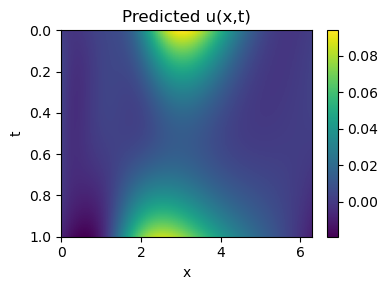

In [7]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinns_pred.png')
plt.show()

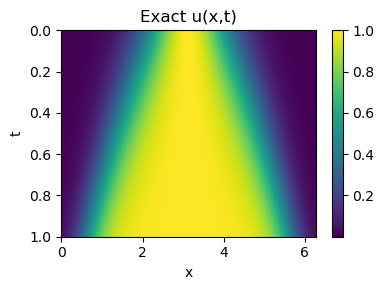

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

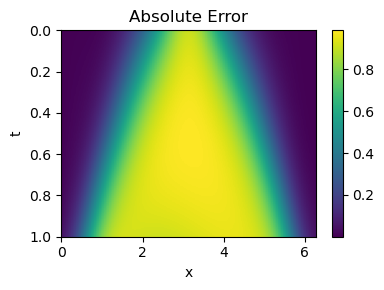

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinns_error.png')
plt.show()

In [10]:
print(loss_track)
loss = [sum(sublist) for sublist in loss_track]
print(loss)
print(max(loss))

[[1.8072905540466309, 0.15118898451328278, 0.42131826281547546], [1.3531666994094849, 0.1236768290400505, 0.39494240283966064], [0.1512114554643631, 0.026211760938167572, 0.2799326479434967], [0.047914739698171616, 0.008500142954289913, 0.2459818422794342], [0.041898373514413834, 0.002695542760193348, 0.22843842208385468], [0.045146580785512924, 0.0016275756061077118, 0.22388014197349548], [0.04617689549922943, 0.0011906081344932318, 0.22198443114757538], [0.04663058742880821, 0.0003603892109822482, 0.21778610348701477], [0.04263051971793175, 0.00024026613391470164, 0.21327371895313263], [0.029623636975884438, 0.0024101317394524813, 0.21021556854248047], [0.014156021177768707, 0.003367607481777668, 0.21116818487644196], [0.004763763397932053, 0.0014200287405401468, 0.21494261920452118], [0.002352438634261489, 0.00045144144678488374, 0.21625708043575287], [0.0014471240574494004, 0.0001087257478502579, 0.21530987322330475], [0.002736712573096156, 4.957741475664079e-05, 0.2086272239685058

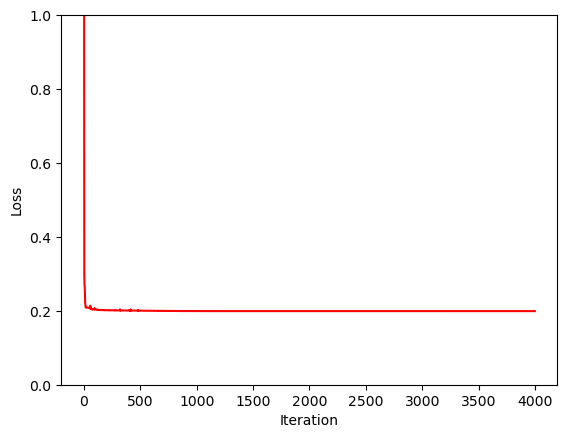

In [11]:
loss = [sum(sublist) for sublist in loss_track]
indices=list(range(len(loss)))
plt.figure()
plt.plot(indices,loss,color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([0,100]) # 设置x轴的范围
plt.ylim([0,1]) # 设置y轴的范围
plt.show()

In [15]:
#EMA模块

import torch
from torch import nn

"""《xPatch: Dual-Stream Time Series Forecasting with Exponential Seasonal-Trend Decomposition》 AAAI 2025
近年来，基于 Transformer 的模型在时间序列预测中的应用受到了广泛关注。尽管 Transformer 架构经常展示出有希望的结果，但由于其注意力机制，它在充分利用时间序列数据中的时间关系方面遇到了挑战。
在这项工作中，我们设计了 eXponential Patch（简称 xPatch），这是一种利用指数分解的新型双流架构。受经典指数平滑方法的启发，xPatch 引入了创新的季节性趋势指数分解模块。
此外，我们提出了一种双流架构，它由基于 MLP 的线性流和基于 CNN 的非线性流组成。该模型研究了在非 Transformer 模型中采用修补和通道独立技术的好处。
最后，我们开发了一个强大的反正切损失函数和一个 S 型学习率调整方案，以防止过度拟合并提高预测性能。
"""


class EMA(nn.Module):
    """
    Exponential Moving Average (EMA) block to highlight the trend of time series
    """

    def __init__(self, alpha):
        super(EMA, self).__init__()
        # self.alpha = nn.Parameter(alpha)    # Learnable alpha
        self.alpha = alpha

    # Optimized implementation with O(1) time complexity
    def forward(self, x):
        # x: [Batch, Time, Channel]
        _, t, _ = x.shape
        # 1. 计算权重
        powers = torch.flip(torch.arange(t, dtype=torch.double), dims=(0,))
        # weights = torch.pow((1 - self.alpha), powers).to('cuda')
        weights = torch.pow((1 - self.alpha), powers).to(x.device)
        # 2. 调整权重
        divisor = weights.clone()
        weights[1:] = weights[1:] * self.alpha
        # 3. 计算加权累积和
        weights = weights.reshape(1, t, 1)
        divisor = divisor.reshape(1, t, 1)
        x = torch.cumsum(x * weights, dim=1)
        # 4. 归一化
        x = torch.div(x, divisor)
        return x.to(torch.float32)


# 设置 alpha 的值，例如 0.1
alpha = 0.1
# block = EMA(alpha).to('cuda')
block = EMA(alpha).to(device)

# [Batch=2, Time=10, Channel=3]
# input = torch.rand(2, 10, 3).to('cuda')
input = torch.rand(2, 10, 3).to(device)

output = block(input)

print("Input size:", input.size())
print("Output size:", output.size())

Input size: torch.Size([2, 10, 3])
Output size: torch.Size([2, 10, 3])
